# El modelo de bigramas usando una red neuronal

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Abrimos el archivo con los nombres
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()
dataset[:8]

In [ ]:
#¿Cuantos nombres tenemos?
len(dataset)

In [ ]:
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}

Vamos a hacer un dataset como para alimentar la red neuronal.

In [ ]:
xs, ys = [], []

for d in dataset[:1]:
    example = ['*'] + list(d) + ['*']
    for c1, c2 in zip(example, example[1:]):
        xs.append(ctoi[c1])
        ys.append(ctoi[c2])
        print(c1, c2)
#xs = torch.tensor(xs)
#ys = torch.tensor(ys)

In [ ]:
xs

In [ ]:
ys

In [ ]:
F.one_hot(xs, num_classes=len(charset)).shape

In [ ]:
nclasses = len(charset)
xenc = F.one_hot(xs, num_classes=nclasses)

In [ ]:
xenc.shape

In [ ]:
plt.imshow(xenc)

In [ ]:
# Remember to make the one_hot float!

# Nuestra "Red Neuronal"

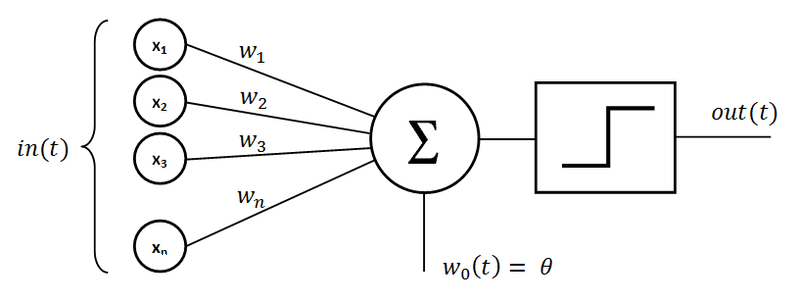

Espero se acuerden de esto. Lo que vamos a hacer es una red neuronal con una sola capa oculta (hidden layer), lineal, sin bias (es decir, sin suma ponderada, solo suma)

In [ ]:
W = torch.randn((nclasses, 1))

In [ ]:
W

In [ ]:
xenc @ W  # [11 x 40] @ [40 x 1] ==> [11 x 1]

In [ ]:
W = torch.randn((nclasses, nclasses))
xenc @ W  # [11 x 40] @ [40 x 40] ==> [11 x 40]

In [ ]:
(xenc @ W)[0]

In [ ]:
plt.imshow(xenc @ W)

La pregunta es que es esto 👆
Cómo interpretamos el output de la red neuronal?
- No son probabilidades porque exceden el rango [0, 1]
- No son counts por que son flotantes y hay negativos

Vamos a interpretar esta salida como log(counts) o logits. Para obtener counts podemos exponenciar. Luego, si normalizamos podemos interpretar la salida como probabilidades.

In [ ]:
logits = xenc @ W  
counts = logits.exp()
probs = counts/counts.sum(axis=1, keepdims=True)

In [ ]:
probs[0]

## Pasando en limpio

In [ ]:
xs

In [ ]:
ys

In [ ]:
g = torch.Generator().manual_seed(42)
W = torch.randn((nclasses, nclasses), generator=g, requires_grad=True)

In [ ]:
# forward pass
xenc = F.one_hot(xs,num_classes=nclasses).float()  # la entrada a la NN en encodeada en one_hot
logits = xenc @ W  # hacemos una predicción de los log(counts)
counts = logits.exp()  # obtenemos la matriz de cuentas
probs = counts / counts.sum(axis=1, keepdims=True)  # obtenemos la matriz de probabilidades

In [ ]:
#probs[0, 20], probs[1,28], probs[2,28], probs[3,20], probs[4, 25] # and so on...

In [ ]:
loss = -probs[range(11), ys].log().mean()
loss # .item()

In [ ]:
# backwards pass
W.grad = None
loss.backward()  # <-- requiere que trackear los gradientes en W

In [ ]:
# update Weights
W.data += -0.1 * W.grad

In [ ]:
# Escriban el trining loop y no se olviden de imprimir el loss y agregar más ejemplos.

## Haciendo inferencia con el modelo

In [ ]:
g = torch.Generator().manual_seed(42)

for i in range(10):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]),num_classes=nclasses).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(axis=1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out[:-1]))